# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


Download the dataset

In [ ]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter row with length greater than 8.


In [ ]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [ ]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]



detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()


Remove from corpus the sentences where any unknow word appears

In [ ]:
mask = np.sum( (sentences==1) , axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [ ]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
test_generator = DataGenerator(original_data)
x, y = test_generator.__getitem__(1)

In [ ]:
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

original:  <start> telephone is one of the fastest mediums to communicate with outside world <end>
shuffled:  <start> one outside telephone with fastest the communicate mediums to is of world <end>


original:  <start> advertising is the art of making whole lies out of half truths <end>
shuffled:  <start> the is half out whole truths art of of making lies advertising <end>


original:  <start> weather changes from day to day and over the seasons <end>
shuffled:  <start> from seasons weather and day day changes to over the <end>


original:  <start> smoking also slows down the healing time <comma> so that it takes longer to get well <end>
shuffled:  <start> so the that to longer get down takes well healing slows it <comma> smoking time also <end>


original:  <start> hypertension increases the risk of heart disease and stroke and can damage eyes and kidneys <end>
shuffled:  <start> stroke can damage risk eyes increases hypertension disease the of and kidneys and and heart <end>


origin

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

# **Introduction**




In this project, I initially explored using simple recurrent neural network (RNN) and long short-term memory (LSTM) architectures to tackle a natural language processing (NLP) task. However, these traditional methods only achieved a maximum accuracy of about 28%, leading to suboptimal results. Recognizing the need for a more advanced approach, I turned to transformer models, which have shown exceptional performance in NLP tasks, particularly where understanding the relationships and positional significance of words within sequences is crucial.

<br><span style="font-size: 16px;">

Transformers, introduced in the paper "Attention is All You Need," have revolutionized the field of NLP due to their ability to process sequences in parallel and their efficiency in learning long-range dependencies. To better understand and implement a transformer model, I referred to a comprehensive TensorFlow tutorial (https://www.tensorflow.org/text/tutorials/transformer) that explains the intricacies of transformers with a detailed example of a model designed to translate Portuguese sentences into English.

<br><span style="font-size: 16px;">

The choice to adapt a transformer model for this project stems from the model’s capability to grasp the intricate dynamics between word connections and positions essential for translating and predicting sequences accurately. While the primary goal in the tutorial was translation, the foundational concepts are directly applicable to my project. However, some adjustments are necessary to tailor the model to the specific needs of this task. For instance, unlike the tutorial where positional encoding is crucial, our input sequences are shuffled, rendering traditional positional encodings irrelevant. This necessitates modifications in the embedding process.

<br><span style="font-size: 16px;">

Additionally, the architecture needs to accommodate dual inputs during training(the shuffled and the correct order of sentences) and predict the ordered sequence with a right shift (i.e., removing the first token and adding a padding token at the end to maintain sequence length). This setup poses unique challenges in redesigning the prediction process typically used in transformers, which usually predict one word at a time. To effectively manage this aspect, we will implement an inference mechanism that allows the model to predict the sequence one word at a time. This strategic modification is aimed at enhancing the model’s ability to accurately reconstruct ordered sequences from their shuffled counterparts.

<br><span style="font-size: 16px;">

By leveraging the advanced capabilities of transformers and making necessary adaptations, this project aims to significantly improve upon the limitations encountered with simpler RNN and LSTM approaches.
<br><span style="font-size: 16px;">


# **Data Pre-proccesing**

We iniatialize our data for splitting them in test and train data. A part (10%) of the train data will be used for validation.

In [ ]:
import numpy as np

# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

**Test Data**

In [ ]:
test_generator = DataGenerator(shuffled_data[220000:])

**Train Data**

As outlined in the introduction, the data needs to be shifted for the training of our model. Initially, using a generator for this purpose wasn't very intuitive for me, so I opted to gather all the shuffled and ordered data into arrays instead. The function below demonstrates how to split the data into x_shuffle and x_ordered arrays, and also shifts the ordered data to create a y_shifted array. This approach streamlines the data preparation phase for our modeling needs.

In [ ]:
def collect_all_batches(generator):
    x_shuffled, x_ordered = [], []
    # Iterate over each batch in the generator
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_shuffled.append(x_batch)  # Collect shuffled input batches
        x_ordered.append(y_batch)  # Collect ordered input batches

    # Convert lists to numpy arrays
    x_shuffled = np.concatenate(x_shuffled, axis=0)  # Concatenate all shuffled inputs
    x_ordered = np.concatenate(x_ordered, axis=0)  # Concatenate all ordered inputs

    # Create y_shifted by shifting and adding a zero
    y_shifted = np.zeros_like(x_ordered)  # Create an array of zeros with the same shape as x_ordered
    y_shifted[:, :-1] = x_ordered[:, 1:]  # Shift elements to the left and lose the first element of each row

    return x_shuffled, x_ordered, y_shifted

In [ ]:
# Create an instance of the generator
train_generator = DataGenerator(shuffled_data[:220000])

# Retrieve all x_train_shuffled, x_train_ordered, and y_train_shifted
x_train_shuffled, x_train_ordered, y_train_shifted = collect_all_batches(train_generator)

In [ ]:
print("Shape of x_train_shuffled:", x_train_shuffled.shape)
print("Shape of x_train_ordered:", x_train_ordered.shape)
print("Shape of y_train_shifted:", y_train_shifted.shape)

Shape of x_train_shuffled: (220000, 28)
Shape of x_train_ordered: (220000, 28)
Shape of y_train_shifted: (220000, 28)


We define the max_tokens, which is the max length of sentence. It is 28 as shown above (also defined in the Dataset section).

In [ ]:
max_tokens = max([len(x) for x in original_data])
max_tokens

28

# **The Model**

Embeddings play a crucial role in capturing relationships between words, which is essential for decoding meaningful sentences in language models. In a standard transformer model, such as the one designed for translating Portuguese to English, positional embeddings are critical for maintaining the order of inputs, which directly influences the generation of coherent translated sentences.

However, in our specific use case where the input consists of shuffled words, the traditional use of positional embeddings in the encoder becomes redundant. Despite this, embeddings are still necessary to capture the semantic relationships between words to ensure the accuracy and effectiveness of the model.

To adapt the model to our needs, we will modify the encoder to use a standard embedding layer without positional information for the shuffled inputs. The decoder, on the other hand, will retain the positional embedding since the order of words is essential for reconstructing meaningful sentences.

In the original implementation of the transformer model on the TensorFlow tutorial page, both the encoder and decoder utilize positional embeddings integrated within the PositionalEmbedding class. This is specified by initializing self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) within the class. For our adjusted model, we'll instead incorporate this embedding layer directly into the transformer's structure for the encoder. This modification not only simplifies the code but also aligns the embedding process with our specific requirements, where the encoder handles shuffled input and the decoder focuses on ordered output.

To ensure clarity and maintain the integrity of the original tutorial structure, all functions and classes sourced from the TensorFlow tutorial have been used as is, where applicable. Any modifications or custom adaptations specific to our project requirements are clearly marked within the code using comment blocks denoted by " ###### CHANGE HERE     ! ###### ".

Link to download the model weight :
https://drive.google.com/file/d/1wZqiGRVLAcD_Zkfz8ROalDp7OyvMZguR/view?usp=drive_link


(It will ask me the authorization, I will be as quick as possible, otherwise here is my email eliottaxel.vigier@studio.unibo.it to contact me directly).

In our model we do not have any convolutional layers so we need a function to identify word order. This will be use to that purpose in the PositionalEmbedding class (used in the decoder). We need the function positional_encoding(length, depth) to calculate the embedding vectors.

In [ ]:
def positional_encoding(length, depth):

    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

Definition of the PositionalEmbedding class used in the decoder. We ajust the definition of the embedding layer which will be defined in our transformer.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
                                                              #######################################
    def __init__(self, vocab_size, d_model, embedding_layer): ########## CHANGE HERE   ! ############
                                                              #######################################
        super().__init__()
        self.d_model = d_model

        #######################################
        ########## CHANGE HERE   ! ############
        #######################################
        self.embedding = embedding_layer
        ######################################
        ########## END OF CHANGE ! ###########
        ######################################

        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):

        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):

        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]

        return x

 BaseAttention is a simple class that contains the component layers. Each use-case will be implemented as a subclass.



In [ ]:
class BaseAttention(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()

This class is used to create cross-attention layer which is the one who relies/connects the encoder and decoder in the transformer.

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, att_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
        )
        self.last_attn_scores = att_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

This layer is responsible for processing the context sequence, and propagating information along its length.

In [ ]:
class GlobalSelfAttention(BaseAttention):

    def call(self, x):

        attn_output = self.mha(
            query=x,
            value=x,
            key=x
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

It is a the same goal as GlobalSelfAttention, but for the outpout sequence.

In [ ]:
class CausalSelfAttention(BaseAttention):

  def call(self, x):

    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Implementation of the network with two linear layers with a ReLU activation in-between, and then a dropout layer.

In [ ]:
class FeedForward(tf.keras.layers.Layer):

  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):

    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)

    return x

Definition of the encoder layer. Each of them contains a GlobalSelfAttention and FeedForward layer.



In [ ]:
class EncoderLayer(tf.keras.layers.Layer):

  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):

    x = self.self_attention(x)
    x = self.ffn(x)

    return x

The encoder have a stack of encoder layers. We take care of the ajustement of the embedding_layer.

In [ ]:
class Encoder(tf.keras.layers.Layer):
                                                                                                           #####################################
  def __init__(self, num_layers, d_model, embedding_layer, num_heads, dff, vocab_size, dropout_rate=0.1):  ########## CHANGE HERE ! ############
    super().__init__()                                                                                     #####################################

    self.d_model = d_model
    self.num_layers = num_layers

#######################################
########## CHANGE HERE   ! ############
#######################################

    self.regular_embedding = embedding_layer

######################################
########## END OF CHANGE ! ###########
######################################

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)                               #####################################
    x = self.regular_embedding(x)  # Shape `(batch_size, seq_len, d_model)`. ########## CHANGE HERE ! ############
                                                                             #####################################
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


Definition of the decoder layer. Each of them containing a CausalSelfAttention, a CrossAttention, and FeedForward layer.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):

    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):

    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores are cached for later plotting
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

    return x

Thee decoder have a stack of DecoderLayer. We take care of the ajustement of the embedding_layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
                                                                                                          #######################################
  def __init__(self, num_layers, d_model, embedding_layer, num_heads, dff, vocab_size, dropout_rate=0.1): ########## CHANGE HERE   ! ############
                                                                                                          #######################################
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    #######################################
    ########## CHANGE HERE   ! ############
    #######################################

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model, embedding_layer = embedding_layer) ########## CHANGE HERE   ! ############

    ######################################
    ########## END OF CHANGE ! ###########
    ######################################

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Now we can create our Transformer by putting together our Encoder and Decoder. We take care of the ajustement of the embedding_layer.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    #######################################
    ########## CHANGE HERE   ! ############
    #######################################

    self.embedding_layer = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)

    ######################################
    ########## END OF CHANGE ! ###########
    ######################################


    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           embedding_layer = self.embedding_layer, ########## CHANGE HERE   ! ############
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           embedding_layer = self.embedding_layer, ########## CHANGE HERE   ! ############
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.

    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

# **Training**


Here’s an explanation of each hyperparameter defined for our transformer model:



1. num_layers

This parameter determines the number of encoder and decoder layers in the transformer. Each layer consists of sub-layers, including multi-head attention mechanisms and feed-forward neural networks.

We have increased the number of layers (num_layers = 6) to enhance the model's ability to learn more complex patterns and relationships in the data. This adjustment was made without a constraint on training time, allowing for more depth in the model architecture.



2. d_model

This is the dimensionality of the input and output of the model layers. It directly affects the size and complexity of the model.

We did not change the d_model from a typical size of 128 to ensure the total number of parameters stayed less than 20 million, adhering to our model complexity constraints.



3. dff

This stands for the dimensionality of the feed-forward network model within each encoder and decoder layer.

We kept the dff at 512, a standard size that provides a good balance between computational efficiency and the ability to process complex features in the data.



4. num_heads

This parameter specifies the number of attention heads in the multi-head attention mechanisms. More heads allow the model to simultaneously attend to different parts of the input sequence, a crucial aspect for understanding nuanced relationships in the data.

We increased the number of heads to 10, enhancing the model’s capacity to focus on various aspects of the input data simultaneously. This was feasible as we do not have stringent time constraints for the model training.



5. dropout_rate

Dropout rate refers to the probability of setting a neuron to zero during the training phase. It is a regularization technique used to prevent overfitting in neural networks.

The dropout rate was maintained at 0.1, which is a typical value that helps prevent overfitting without compromising the model's ability to learn from the training data.


In [ ]:
# Hyperparameters definition
num_layers = 6
d_model = 128
dff = 512
num_heads = 10
dropout_rate = 0.1

Adam optimizer with a custom learning rate scheduler.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Implementation of the optimizer.

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

We use here a custom loss function because the target sequences are padded, so we are applying a padding mask when we calculate the loss.

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Let's iniate the model.


In [ ]:
transformer = Transformer(num_layers=num_layers, d_model=d_model,
                          num_heads=num_heads, dff=dff,
                          input_vocab_size=10_000, target_vocab_size=10_000,
                          dropout_rate=dropout_rate)

Compilation.

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

Building the model.

We also do a summary to see the architecture of the model (16 026 128 < 20M parameters).

In [ ]:
transformer.build(input_shape = [(None, max_tokens), (None, max_tokens)])

transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  1280000   
                                                                 
 encoder_1 (Encoder)         multiple                  6029312   
                                                                 
 decoder_1 (Decoder)         multiple                  9986816   
                                                                 
 dense_49 (Dense)            multiple                  1290000   
                                                                 
Total params: 16026128 (61.13 MB)
Trainable params: 16026128 (61.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can now iniate the training.


In [ ]:
from keras.callbacks import EarlyStopping

# Parameters
train_data = (x_train_shuffled, x_train_ordered)
epochs = 30
batch_size= 256
stop = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=4, restore_best_weights=True)
validation_split = 0.1

# Training
history = transformer.fit(train_data, y_train_shifted,
                          epochs=epochs, batch_size=batch_size,
                          callbacks = [stop], validation_split = validation_split)

# Saving the weights of the model
transformer.save_weights('model/transformer_weights.ckpt')

Epoch 1/30
774/774 [==============================] - 424s 483ms/step - loss: 6.9071 - masked_accuracy: 0.2204 - val_loss: 4.8181 - val_masked_accuracy: 0.3672
Epoch 2/30
774/774 [==============================] - 371s 479ms/step - loss: 3.7301 - masked_accuracy: 0.4743 - val_loss: 2.4919 - val_masked_accuracy: 0.6117
Epoch 3/30
774/774 [==============================] - 375s 485ms/step - loss: 2.0843 - masked_accuracy: 0.6431 - val_loss: 1.5492 - val_masked_accuracy: 0.7054
Epoch 4/30
774/774 [==============================] - 372s 480ms/step - loss: 1.4108 - masked_accuracy: 0.7086 - val_loss: 1.2873 - val_masked_accuracy: 0.7267
Epoch 5/30
774/774 [==============================] - 375s 485ms/step - loss: 1.1630 - masked_accuracy: 0.7354 - val_loss: 1.0377 - val_masked_accuracy: 0.7620
Epoch 6/30
774/774 [==============================] - 371s 479ms/step - loss: 1.0222 - masked_accuracy: 0.7550 - val_loss: 0.9299 - val_masked_accuracy: 0.7777
Epoch 7/30
774/774 [====================

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1280000   
                                                                 
 encoder (Encoder)           multiple                  6029312   
                                                                 
 decoder (Decoder)           multiple                  9986816   
                                                                 
 dense_24 (Dense)            multiple                  1290000   
                                                                 
Total params: 16026128 (61.13 MB)
Trainable params: 16026128 (61.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


A few graphics of the training.

In [ ]:
import matplotlib.pyplot as plt

# Extracting the data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['masked_accuracy']
val_acc = history.history['val_masked_accuracy']

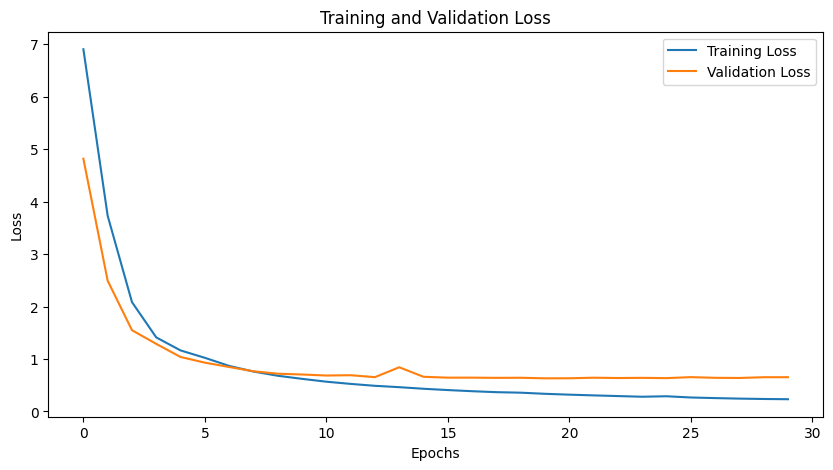

In [ ]:
# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

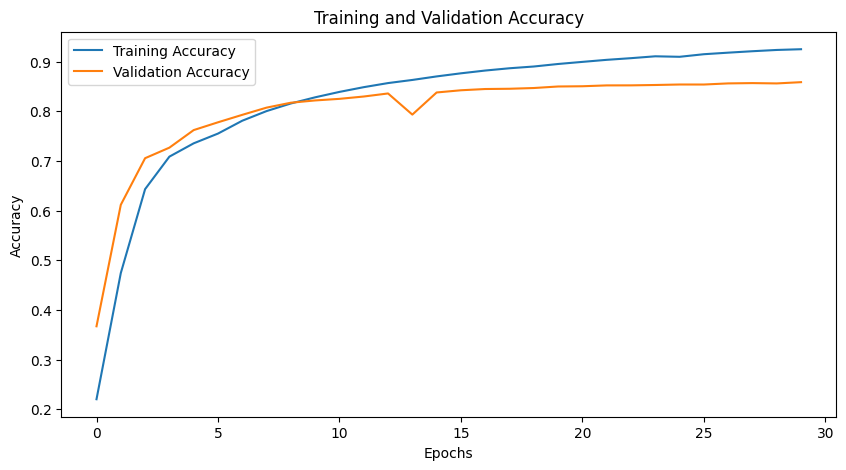

In [ ]:
# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This part was for saving and loading the model weight. It was useful for comparing different hyperamaters definition.

In [ ]:
# Saving the weights of the model
# transformer.save_weights('model/transformer_weights.ckpt')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/model.zip ./
# !unzip model.zip

Mounted at /content/drive
Archive:  model.zip
  inflating: model/checkpoint        
  inflating: model/transformer_weights.ckpt.data-00000-of-00001  
  inflating: model/transformer_weights.ckpt.index  


In [ ]:
# # Loading the weights of the model
# transformer.load_weights('model/transformer_weights.ckpt')

In [ ]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  1280000   
                                                                 
 encoder_1 (Encoder)         multiple                  6029312   
                                                                 
 decoder_1 (Decoder)         multiple                  9986816   
                                                                 
 dense_49 (Dense)            multiple                  1290000   
                                                                 
Total params: 16026128 (61.13 MB)
Trainable params: 16026128 (61.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Prediction with inference and Score metric**

The Reorder class encapsulates a process of conducting inference with a transformer model to restore the correct order of shuffled tokens within a sequence. Upon initialization with a transformer and a tokenizer, and when called with a batch of shuffled tokens, the class systematically predicts and constructs a coherent sequence starting with a predefined start token. Throughout the inference process, it iteratively selects the most probable next token based on the transformer's predictions, appending it to the output and removing it from the pool of remaining tokens to avoid repetition. This continues until all tokens are utilized or the sequence is terminated with an end token, thereby reconstructing the original sequence from its disordered state.

In [ ]:
import keras

class Reorder(tf.Module):
    def __init__(self, transformer):
        self.transformer = transformer
        self.start_token = 3
        self.end_token = 2

    # A list of list of all the different tokens of a each sentences
    def prepare_tokens(self, shuffled_tokens_batch):
        # Prepare token lists by filtering out start and end tokens
        all_tokens_per_sentence_list = []

        for shuffled_tokens in shuffled_tokens_batch:

            all_tokens_one_sentence = []

            for token in shuffled_tokens:

                if token not in [self.start_token, self.end_token]:

                    all_tokens_one_sentence.append(token)
            # Append the list of tokens for one sentence directly to the main list
            all_tokens_per_sentence_list.append(all_tokens_one_sentence)

        return all_tokens_per_sentence_list


    def __call__(self, shuffled_tokens_batch, max_length=max_tokens):

        # all the tokens for the predictions excepts the start and end ones. All the possible tokens for each shuffle_tokens. The model will predict which one to use.
        all_tokens = self.prepare_tokens(shuffled_tokens_batch)

        # Encoder input
        encoder_input = shuffled_tokens_batch

        # Future output : reordered future predictions. They need to start with the start token 2, it is not in the prediction model. Will be use for the decoder input.
        output = []
        # batch size is the number of inputs ie size of the batch defined in the test_generator.
        batch_size = len(shuffled_tokens_batch)
        for i in range(batch_size):

          token_sentence = []
          token_sentence.append(self.start_token)
          output.append(token_sentence)


        # The transformer will predict word by word.
        for token in range(1, max_length): # since there is token start already.
            # The decoder has only the token start at the beginning and then earn one by one a token at each iteration.
            decoder_input = np.array(tf.convert_to_tensor(output))
            # Calculating the predictions for all tokens
            predictions = np.array(self.transformer((encoder_input, decoder_input), training = False))
            predictions = predictions[:, -1, :]

            # looping on all sentences of the batch and predicting one next token for each of them
            for sentence in range(batch_size):

                # Checking if all the tokens are already predicted
                if len(all_tokens[sentence]) != 0:

                  # If not all the tokens are already predicted, we calculated the probabilties of each token of the model
                  all_tokens_pred_prob = predictions[sentence, np.array(all_tokens[sentence])]
                  # We take the best one
                  pred_token_index = np.argmax(all_tokens_pred_prob)
                  # Store the value
                  pred_token = all_tokens[sentence][pred_token_index]
                  # Remove the index to not predict it again
                  all_tokens[sentence].pop(pred_token_index)

                else:
                  # If we have predict all the tokens, we can end there and put the end token 3
                  pred_token = self.end_token

                # We add the token to our final output which is not finish yet
                output[sentence].append(pred_token)

        # To have a sentence
        sentence_output = detokenizer(output)

        return sentence_output

We need a function to have the correct format to calculate the score metric. We use clear_sentence(sentence) to remove < start > and < end >. It also replaces < comma > by ",".

In [ ]:
# Have a good format for the final metrics
def clear_sentence(sentence):
    sentence = sentence.replace('<start>', '')
    sentence = sentence.replace('<end>', '')
    sentence = sentence.replace('<comma>', ',')
    sentence = sentence.strip()
    return sentence

We have this function to know the number of word in a string.

In [ ]:
def count_words(text):
    # Split the string into segments based on whitespace, then filter out non-alphabetic 'words'
    words = text.split()
    alphabetic_words = [word for word in words if word.isalpha()]
    return len(alphabetic_words)

We can now use the model on our test data.

In [ ]:
def predictions(number_of_batch):

  batch_size = 32 # written in the dataGenerator class
  score_list = []
  number_of_test_done = 0
  sum_score = 0
  count_words_list = []

  reorderer = Reorder(transformer)

  for batch in range(number_of_batch):

      # obtaining shuffle and normal sentences association
      x_test, y_test = test_generator.__getitem__(batch)
      # to have a sentence
      x_test_sentence =  detokenizer(x_test)
      y_test_sentence =  detokenizer(y_test)

      # prediction on the batch x_test
      reordered_token = reorderer(x_test)

      for sentence in range(batch_size):

          # removal of <start> and <end> and <comma>
          shuffled_sentence = clear_sentence(x_test_sentence[sentence])
          # print(shuffled_sentence)

          # removal of <start> and <end> and <comma>
          reodered_sentence = clear_sentence(reordered_token[sentence])
          # print(reodered_sentence)

          # removal of <start> and <end> and <comma>
          original_sentence = clear_sentence(y_test_sentence[sentence])
          # print(original_sentence)

          # updating the score
          score_sentence = score(original_sentence, reodered_sentence)
          # print(score_sentence)

          score_list.append(score_sentence)
          count_words_list.append(count_words(original_sentence))
          sum_score = sum_score + score_sentence

          number_of_test_done = number_of_test_done + 1

          if number_of_test_done % 1000 == 0:
            print(f"Mean score for {number_of_test_done} sentences : {sum_score/number_of_test_done}")

  # final score
  mean_score = sum_score/(number_of_test_done)
  print(f"Mean score for {number_of_test_done} sentences :{mean_score}")
  return score_list, count_words_list

number_of_batch = 200 # To have 3k test sentences (200 * 32 = 6400)

score_list, count_words_list = predictions(number_of_batch)

Mean score for 1000 sentences : 0.5457419093809865
Mean score for 2000 sentences : 0.5532498554280788
Mean score for 3000 sentences : 0.5492981429502267
Mean score for 4000 sentences : 0.5470289763145819
Mean score for 5000 sentences : 0.5477660117011418
Mean score for 6000 sentences : 0.5472545439179557
Mean score for 6400 sentences :0.5476241341062792


Let's have a look to the repartion of our scores.




# **Analyze of the data**

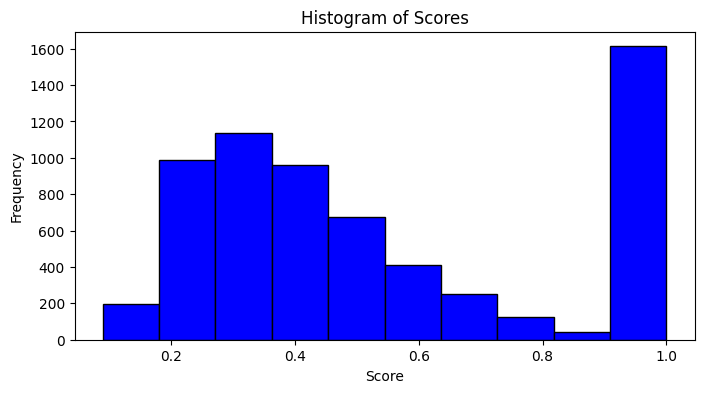

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))  # Set the figure size
plt.hist(score_list, bins=10, color='blue', edgecolor='black')  # Create histogram
plt.title('Histogram of Scores')  # Add a title
plt.xlabel('Score')  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis
plt.show()  # Display the histogram

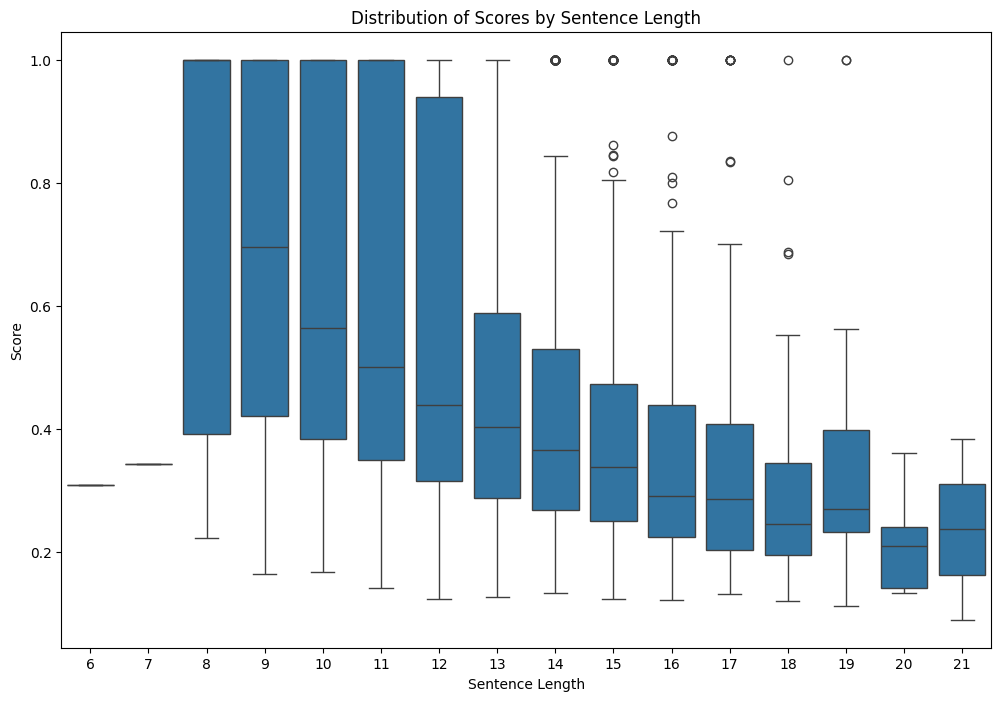

In [ ]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame({
    'Sentence Length': count_words_list,
    'Score': score_list
})

plt.figure(figsize=(12, 8))
sns.boxplot(x='Sentence Length', y='Score', data=data)
plt.title('Distribution of Scores by Sentence Length')
plt.show()

The box plot data reveals a clear trend: as sentence length increases, the median score tends to decrease, particularly noticeable from sentence lengths of 15 words (below ~ 0.3) and beyond. This trend suggests that the model's performance degrades with increasing sentence complexity, which is often associated with longer sentences.

It also shows a wider spread in scores for longer sentences, with lower quartiles dipping more significantly as sentence length increases. This increased spread indicates growing inconsistency in the model’s performance as sentences become longer.

In [ ]:
count_of_ones = score_list.count(1)
print(f"Number of scores equal to 1: {count_of_ones} for {len(score_list)} sentences." )
print(f"Percentage in all the data: {(count_of_ones / len(score_list)) * 100:.2f}%")

# Calculate the percentage of scores less than 0.5
count_below_half = sum(1 for score in score_list if score < 0.5)
percentage_below_half = (count_below_half / len(score_list)) * 100
print(f"Percentage of scores less than 0.5: {percentage_below_half:.2f}%")

Number of scores equal to 1: 1607 for 6400 sentences.
Percentage in all the data: 25.11%
Percentage of scores less than 0.5: 56.80%


While 56.80% of the scores fall below 0.5, indicating that a substantial number of predictions substantially deviate from the target configurations, the overall average score of approximately 0.548 reflects a moderate performance across the dataset. This suggests that when the model does perform above the 50% threshold, its predictions are generally more accurate and closer to the target (closer to 1). This dichotomy underscores the need for improvements in handling complex sentence structures probably with more atypical/difficult linguistic patterns.

It is also shown with the 25.11% predictions of score 1. This demonstrates the model's strong capability to reorder sentence components precisely, especially when it predicts with more than 50% score accuracy.

We clearly see all this on the histogram.


# **Conclusion**

The Transformer model shows moderate overall performance with an average score of approximately 0.548, indicating a balanced capability in reordering sentences accurately. However, the significant spread and lower scores in cases with longer sentence lengths (particularly evident for sentences over 15 words) reveal that the model struggles with complex structures and increased sentence length. This degradation is highlighted by 56.80% of scores falling below 0.5, underscoring a substantial deviation from target configurations in more than half of the cases.

Yet, the model has demonstrated a strong capacity to perfectly reorder sentences in about 25.11% of the instances, showcasing its potential effectiveness, particularly when scores exceed the 50% threshold. To address the noted inconsistencies and enhance the model's handling of complex and atypical linguistic patterns, several strategies could be considered:

Post-Processing: Implementing additional steps after initial predictions to refine and correct outputs.

Data Augmentation: Expanding the training dataset with variations of existing data or entirely new data to improve the model's learning scope and robustness.

Model Parameters: Adjusting or tuning the model's parameters to optimize performance for longer and more complex sentences.

Pre-trained Models: Leveraging pre-trained models as a starting point to benefit from previously learned linguistic patterns and structures.

These enhancements could significantly boost the model’s accuracy.
